In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import json
import os
import py_vncorenlp
from underthesea import sent_tokenize
import numpy as np
from rank_bm25 import BM25Okapi
from numpy.random import normal
from scipy.stats import truncnorm, boxcox, gamma
import matplotlib.pyplot as plt
import math
import os, sys
sys.path.append("../src")

from sentences_selection import select_sentences
from util import no_accent_vietnamese
import copy

/home/arch/Projects/college/dsc/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=os.path.abspath('../vncorenlp'))

2023-10-28 19:22:03 INFO  WordSegmenter:24 - Loading Word Segmentation model


In [3]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

In [4]:
import re
def no_accent_vietnamese(s):
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ÌÍỊỈĨ]', 'I', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[ỲÝỴỶỸ]', 'Y', s)
    s = re.sub(r'[Đ]', 'D', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

def sentences_splitting(text, rdrsegmenter=rdrsegmenter):

    text_lower = no_accent_vietnamese(text.lower())
    
    original_sents=[]
    processed_sents = []
    
    text_pos = 0
    for _, sent in rdrsegmenter.annotate_text(text).items():
        words = [w["wordForm"] for w in sent]
        words = [w.replace("_", " ") if w != "_" else "_" for w in words]

        processed_sents.append(" ".join(words))

        words = [no_accent_vietnamese(w.lower()) for w in words]
        words = sum([w.split() for w in words],[])


        # find position of words in text_lower
        pos_start = []
        pos_end = []

        for w in words:
            idx = text_lower.find(w,text_pos)

            pos_start.append(idx)
            pos_end.append(idx + len(w))

            text_pos = idx + len(w)
        
        # for testing
        # test = [text_lower[pos_start[i]: pos_end[i]] for i in range(len(pos_start))]
        # assert test == words

        original_sents.append(text[pos_start[0]: pos_end[-1]])
    return original_sents, processed_sents


In [5]:
data = pd.read_json("../datasets/ise-dsc01-public-test-offcial.json", orient="index")

In [6]:
idx = 29706

In [7]:
data.sample(n=1).reset_index().loc[0]

index                                                  39042
context    Bai sach chrouk\n\nĐây là món cơm trắng ăn cùn...
claim      Du khách đã từng thưởng thức Kari saraman (cà ...
Name: 0, dtype: object

In [329]:
idx = 29706
sample = data.sample(n=1).reset_index().loc[0]
text = sample["context"]
claim = sample["claim"]
context = rdrsegmenter.word_segment(text)

In [330]:
def clean_str(s):
    return ''.join(e.lower() if e.isalnum() else " " for e in s)

In [331]:
query = no_accent_vietnamese(clean_str(claim)).split()
query

['co',
 'rat',
 'nhieu',
 'nghe',
 'si',
 'xinh',
 'dep',
 'tham',
 'gia',
 'man',
 'dieu',
 'hanh',
 'nguoi',
 'khong',
 'lo',
 'thuc',
 'giac']

In [332]:
[no_accent_vietnamese(clean_str(doc)) for doc in context]

['trong ky nghi le keo dai 5 ngay dip 30 4   1 5   cac khu vui choi giai tri cua sun group tai sa pa   ha long   da nang   phu quoc   tay ninh     se co them loat le hoi   su kien cung cac chuong trinh uu dai   hua hen mang toi du khach ky nghi thu vi  ',
 'le hoi hoa hong tai sa pa dip 30 4   sa pa se khai hoi mua he voi chuoi su kien   le hoi mang dam dau an van hoa ban dia  ',
 'mo dau chuong trinh la le hoi duong pho   sa pa mong mi     voi hoat dong dieu hanh va bieu dien nghe thuat thuc hien boi 750 nghe nhan   dien vien den tu 8 dan toc sa pa va lai chau  ',
 'noi bat trong cac hoat dong se la le hoi hoa hong fansipan   dien ra tu 27 4   30 5  ',
 'dai dien sun group cho biet   le hoi duoc to chuc tai thung lung hoa hong   thuoc quan the nha ga di cap treo tai khu du lich sun world fansipan legend  ',
 'khu vuc co dien tich 50 000 m2   quy tu khoang 300 000 goc hong   thuoc 150 giong hoa hong   tu hong leo dac san cua sa pa   hong co sa pa den hong nhap ngoai nhu monileux   soci

In [333]:
bm25 = BM25Okapi([no_accent_vietnamese(clean_str(doc)).split() for doc in context])

In [334]:
query_score = bm25.get_scores(query=query)
query_score

array([ 0.41063458,  0.        ,  6.84879804,  0.        ,  0.        ,
        0.62871337,  4.29326833,  6.91032156, 10.49661586,  1.79101525,
        4.20187774,  4.46670423,  1.9505375 ,  4.54845754,  3.08891353,
        0.        ,  3.63498065,  2.14674774,  4.77349091, 10.15949644,
        0.        , 18.32096279,  1.23882442,  0.66869832,  4.38198252,
        0.        ,  0.61762624,  1.63275465,  0.756247  ,  5.93676494,
        2.3741253 ,  1.44683757,  0.        ,  2.0248879 ,  0.        ,
        0.40246   ,  0.        ,  4.67969194,  3.42982191,  1.5772313 ,
        0.        ])

In [335]:
def distribute_score(score, arr_len, pos):
    if arr_len == 1:
        return [score]
    myclip_a = 0
    myclip_b = 1
    my_mean = pos/(arr_len - 1)
    my_std = 0.75 / arr_len
    
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

    x_range = np.linspace(0,1,arr_len)

    y = truncnorm.pdf(x_range, a, b, loc = my_mean, scale = my_std)

    return score*y/sum(y)
    

In [336]:
# final_doc_scores = np.zeros(len(query_score))

final_doc_scores = sum([distribute_score(score,len(query_score), idx) for idx, score in enumerate(query_score)])
sorted_ids = sorted(range(len(context)), key=lambda k: final_doc_scores[k], reverse=True)

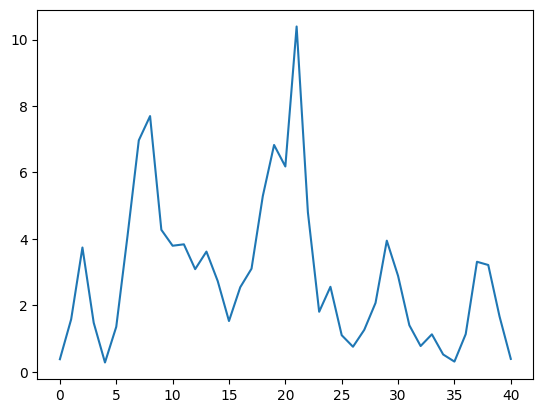

In [337]:
x = range(len(context))

plt.plot(x, final_doc_scores)

In [338]:
claim

'Có rất nhiều nghệ sĩ xinh đẹp tham gia màn diễu hành Người khổng lồ thức giấc '

In [339]:
[context[i] for i in sorted_ids]

['Ngoài_ra , khu du_lịch cũng sẽ ra_mắt show diễn chủ_đề toàn toàn mới tại quảng_trường Noel và màn diễu_hành " Người khổng_lồ thức_giấc " tại quảng_trường Nhật_thực .',
 'Nghỉ_dưỡng với giá ưu_đãi tại Hạ_Long Du_khách đến Hạ_Long sẽ có cơ_hội tham_gia lễ_hội Carnaval 2023 với sự góp_mặt của 2.000 diễn_viên , ca_sĩ , người_mẫu và thưởng_thức pháo_hoa dịp lễ 30/4 .',
 'Trải khắp thung_lũng còn là những tiểu cảnh , đại cảnh kết_từ hoa_hồng , những chiếc nhẫn khổng_lồ , đôi cánh và thiên_nga , đem đến nhiều không_gian check-in độc_đáo cho du_khách .',
 'Cùng với đó là hàng_loạt chương_trình biểu_diễn với sự tham_gia của hơn 150 nghệ_sĩ quốc_tế .',
 'Các hoạt_động bao_gồm tung_hứng , cà_kheo , ảo_thuật đường_phố , hề đường_phố , hoạt_cảnh chủ_đề " Chasing the Sun " ... diễn ra từ 10h đến 16h hàng ngày từ ngày 1/6 đến 31/8 .',
 'Du_khách có cơ_hội nếm thử các hương_vị bia Đức trong không_gian âm_nhạc rộn_ràng và nhiều món ăn phong_cách châu_Âu .',
 'Công_viên châu_Á - Asia_Park cũng sẽ là m

In [340]:
model_max_length = 256
claim_tk_length = len(tokenizer(claim).input_ids[:-1])
abstract_len = model_max_length - claim_tk_length - 1
context_tk_length = [len(tokenizer(s).input_ids[:-1]) for s in context]

In [341]:
fin_len = 0
mask = [0 for _ in range(len(sorted_ids))]
for i in sorted_ids:
    if fin_len + context_tk_length[i] > abstract_len:
        break
    
    fin_len += context_tk_length[i]
    mask[i] = 1

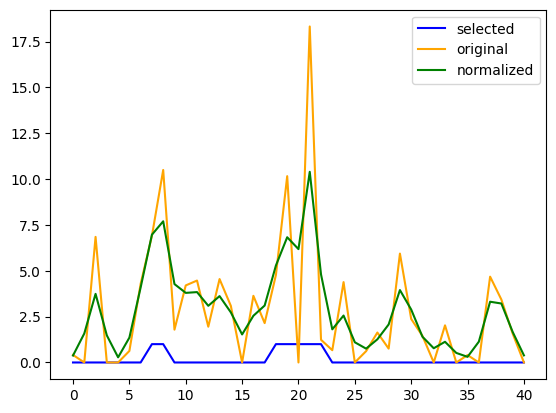

In [342]:
plt.plot(x, mask,color="blue", label="selected")
# original
plt.plot(x, query_score,color="orange",label="original")
# normalized
plt.plot(x, final_doc_scores,color="green", label="normalized")
plt.legend(loc='best')
plt.show()

In [343]:
[context[i] for i in range(len(context)) if mask[i] == 1]

['Trải khắp thung_lũng còn là những tiểu cảnh , đại cảnh kết_từ hoa_hồng , những chiếc nhẫn khổng_lồ , đôi cánh và thiên_nga , đem đến nhiều không_gian check-in độc_đáo cho du_khách .',
 'Nghỉ_dưỡng với giá ưu_đãi tại Hạ_Long Du_khách đến Hạ_Long sẽ có cơ_hội tham_gia lễ_hội Carnaval 2023 với sự góp_mặt của 2.000 diễn_viên , ca_sĩ , người_mẫu và thưởng_thức pháo_hoa dịp lễ 30/4 .',
 'Du_khách có cơ_hội nếm thử các hương_vị bia Đức trong không_gian âm_nhạc rộn_ràng và nhiều món ăn phong_cách châu_Âu .',
 'Cùng với đó là hàng_loạt chương_trình biểu_diễn với sự tham_gia của hơn 150 nghệ_sĩ quốc_tế .',
 'Các hoạt_động bao_gồm tung_hứng , cà_kheo , ảo_thuật đường_phố , hề đường_phố , hoạt_cảnh chủ_đề " Chasing the Sun " ... diễn ra từ 10h đến 16h hàng ngày từ ngày 1/6 đến 31/8 .',
 'Ngoài_ra , khu du_lịch cũng sẽ ra_mắt show diễn chủ_đề toàn toàn mới tại quảng_trường Noel và màn diễu_hành " Người khổng_lồ thức_giấc " tại quảng_trường Nhật_thực .',
 'Công_viên châu_Á - Asia_Park cũng sẽ là m

In [344]:
claim

'Có rất nhiều nghệ sĩ xinh đẹp tham gia màn diễu hành Người khổng lồ thức giấc '

# context slicing
slice a single context into multiple smaller context 

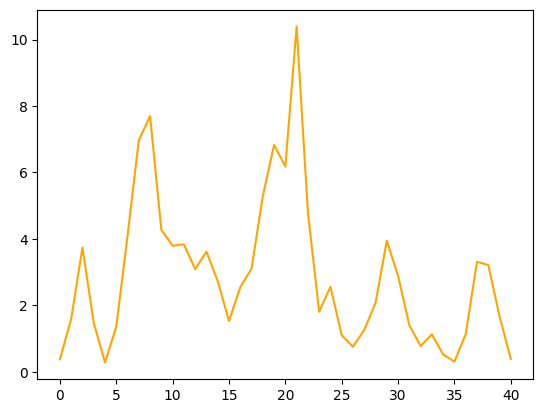

In [345]:
plt.plot(x, final_doc_scores,color="orange",label="original")
plt.show()

In [346]:
context_tk_length


[50,
 23,
 32,
 18,
 26,
 68,
 28,
 35,
 37,
 25,
 23,
 18,
 37,
 51,
 56,
 28,
 27,
 21,
 21,
 17,
 37,
 30,
 39,
 20,
 22,
 31,
 25,
 26,
 12,
 42,
 61,
 24,
 22,
 27,
 23,
 64,
 22,
 34,
 21,
 47,
 3]

In [347]:
def get_longest_continuest_context(tokenized_sents_lenght, start_pos, max_token_number):
    if start_pos >= len(tokenized_sents_lenght):
        return [], 0
    selected = []
    curr_length = 0
    for idx in range(start_pos, len(tokenized_sents_lenght)):
        if curr_length + tokenized_sents_lenght[idx] > max_token_number:
            break
        selected.append(idx)
        curr_length += tokenized_sents_lenght[idx]
    
    return selected, curr_length

In [348]:
def get_best_continuest_context(tokenized_sents_lenght, query_score, max_token_number=200):
    best_context = []
    max_score = 0
    for i in range(len(tokenized_sents_lenght)):
        selected, curr_length = get_longest_continuest_context(tokenized_sents_lenght, start_pos=i, max_token_number=max_token_number)
        score = sum([query_score[i] for i in selected])
        if score > max_score:
            best_context = selected
            max_score = score
    return best_context, max_score

In [349]:
best_context, max_score = get_best_continuest_context(
    tokenized_sents_lenght=context_tk_length,
    query_score=final_doc_scores
)

print([context[i] for i in best_context])

['Đại_diện Sun_Group cho biết , dịp lễ 30/4 - 1/5 nơi đây sẽ chiêu_đãi du_khách bằng loạt hoạt_động biểu_diễn đường_phố , chương_trình âm_nhạc , diễu_hành ...', "Cụ_thể , Sun_World_Ba_Na Hills sẽ tổ_chức lễ_hội ẩm_thực và bia B ' estival từ 30/4 đến hết 31/8 .", 'Du_khách có cơ_hội nếm thử các hương_vị bia Đức trong không_gian âm_nhạc rộn_ràng và nhiều món ăn phong_cách châu_Âu .', 'Cùng với đó là hàng_loạt chương_trình biểu_diễn với sự tham_gia của hơn 150 nghệ_sĩ quốc_tế .', 'Các hoạt_động bao_gồm tung_hứng , cà_kheo , ảo_thuật đường_phố , hề đường_phố , hoạt_cảnh chủ_đề " Chasing the Sun " ... diễn ra từ 10h đến 16h hàng ngày từ ngày 1/6 đến 31/8 .', 'Ngoài_ra , khu du_lịch cũng sẽ ra_mắt show diễn chủ_đề toàn toàn mới tại quảng_trường Noel và màn diễu_hành " Người khổng_lồ thức_giấc " tại quảng_trường Nhật_thực .', 'Công_viên châu_Á - Asia_Park cũng sẽ là một điểm đến giải_trí hấp_dẫn ở trung_tâm Đà_Nẵng trong dịp nghỉ lễ lớn này , với chuỗi sự_kiện nghệ_thuật Wow_Summer diễn ra từ

In [350]:
def slice_context(tokenized_sents_lenght, number_of_contexts, query_score, max_token_number=200):
    qscores = copy.copy(query_score)
    selected = []

    for _ in range(number_of_contexts*2):
        if len(selected) >= number_of_contexts:
            break
        best_context, max_score = get_best_continuest_context(
            tokenized_sents_lenght=context_tk_length,
            query_score=qscores,
            max_token_number=max_token_number
        )
        
        # reduce the score of the selected context

        for i in best_context:
            qscores[i] /= 3
        print(max_score)
        if best_context not in selected:
            selected.append(best_context)
    return selected

In [351]:
MODEL_MAX_TOKEN = 500

In [352]:
math.ceil(sum(context_tk_length)*1.25/MODEL_MAX_TOKEN)

4

In [353]:
res = slice_context(
    tokenized_sents_lenght=context_tk_length,
    number_of_contexts = math.ceil(sum(context_tk_length)*1.2/MODEL_MAX_TOKEN),
    query_score=final_doc_scores,
    max_token_number=MODEL_MAX_TOKEN
)
res

75.9815769901873
35.62042534200833
21.803944456298428
15.307650739685943


[[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
 [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]]

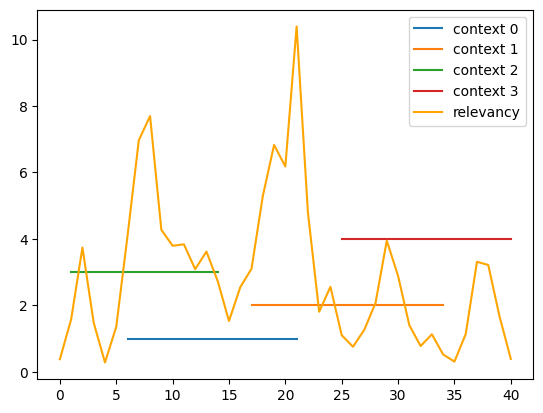

In [354]:

for idx,sl in enumerate(res):
    plt.plot(sl, [1 + idx for _ in range(len(sl))], label="context " + str(idx))
plt.plot(x, final_doc_scores,color="orange",label="relevancy")
plt.legend(loc='best')

plt.show()


In [355]:
sum(context_tk_length)

1273

In [356]:
claim

'Có rất nhiều nghệ sĩ xinh đẹp tham gia màn diễu hành Người khổng lồ thức giấc '

In [357]:
[[context[i] for i in sl] for sl in res]

[['Lễ_hội sẽ bắt_đầu bằng một đoàn diễu_hành với 14 chiếc xe_ngựa kéo , xe cổ , xe_điện và xe_đạp được trang_trí bởi hàng triệu đoá hồng .',
  'Trải khắp thung_lũng còn là những tiểu cảnh , đại cảnh kết_từ hoa_hồng , những chiếc nhẫn khổng_lồ , đôi cánh và thiên_nga , đem đến nhiều không_gian check-in độc_đáo cho du_khách .',
  'Nghỉ_dưỡng với giá ưu_đãi tại Hạ_Long Du_khách đến Hạ_Long sẽ có cơ_hội tham_gia lễ_hội Carnaval 2023 với sự góp_mặt của 2.000 diễn_viên , ca_sĩ , người_mẫu và thưởng_thức pháo_hoa dịp lễ 30/4 .',
  'Dịp này , Sun_World_Ha_Long cũng đưa ra nhiều chương_trình ưu_đãi cho du_khách lựa_chọn vui_chơi tại hai hoặc ba công_viên trong tổ_hợp .',
  'Cụ_thể , gói vui_chơi tại hai công_viên sẽ có mức giá 550.000 đồng dành cho người_lớn , 450.000 đồng cho trẻ_em .',
  'Gói vui_chơi đủ ba công_viên có_giá 650.000 đồng dành cho người_lớn , 550.000 đồng cho trẻ_em .',
  'Đến đây , khách_hàng sẽ có cơ_hội trải_nghiệm cáp treo Nữ_Hoàng , hệ_thống trò_chơi hiện_đại tại công_viên